### check
   * exchange balance of bitocin v.s. stables
   * large transfer in of stables v.s. bitcoins -> large trading volume? -> cause price move?

In [2]:
from cdcqr.data.glassnode import glassnode_data as gnd
from cdcqr.ct.utils import plot2
import pandas as pd
import cdcqr.analytics.utils as autil 
from importlib import reload
import seaborn as sns
import matplotlib.pyplot as plt
from cdcqr.analytics.utils import calculate_corr_pvalues
from cdcqr.common.utils import LOCAL_DATA_DIR
import os
import numpy as np

C:\Users\Wang\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
gn = gnd.GlassnodeData()

In [4]:
gn.get_feature_best_resolutions('balance_exchanges')

'10m'

In [5]:
[x for x in gn.get_feature_assets('balance_exchanges') if 'USD' in x]

['GUSD', 'USDT', 'USDP', 'USDC', 'BUSD', 'USDK', 'sUSD', 'HUSD']

In [6]:
reload(gnd)
gn = gnd.GlassnodeData()

In [7]:
fs = ['price_usd_close', 'balance_exchanges']
assets = ['BTC','USDT', 'USDC', 'BUSD']
df = gn.load_features(fs, assets, resolution='10m')

loading market/price_usd_close asset=BTC, resolution=10m
loading market/price_usd_close asset=USDT, resolution=10m
loading market/price_usd_close asset=USDC, resolution=10m
loading market/price_usd_close asset=BUSD, resolution=10m
loading distribution/balance_exchanges asset=BTC, resolution=10m
loading distribution/balance_exchanges asset=USDT, resolution=10m
loading distribution/balance_exchanges asset=USDC, resolution=10m
loading distribution/balance_exchanges asset=BUSD, resolution=10m


<AxesSubplot:xlabel='t'>

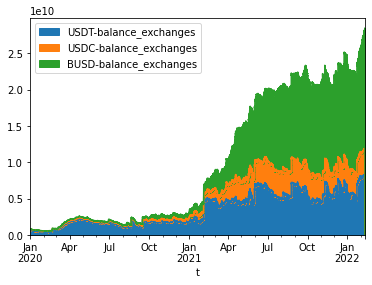

In [9]:
df[df.index>='20200101'][['USDT-balance_exchanges','USDC-balance_exchanges','BUSD-balance_exchanges']].plot.area()

In [10]:
df1 = df[df.index>='20200101'].ffill().drop(['USDT-price_usd_close','USDC-price_usd_close','BUSD-price_usd_close'],axis=1)
df1['stable-balance_exchanges'] = df['USDT-balance_exchanges']+df['USDC-balance_exchanges']+df['BUSD-balance_exchanges']
df1 = df1[['BTC-price_usd_close', 'stable-balance_exchanges','BTC-balance_exchanges']]
df1.head()

,BTC-price_usd_close,stable-balance_exchanges,BTC-balance_exchanges
t,,,
2020-01-01 00:00:00,7189.532563,8.618036e+08,3.027352e+06
2020-01-01 00:10:00,7182.082862,8.618286e+08,3.027421e+06
2020-01-01 00:20:00,7180.116033,8.617651e+08,3.027421e+06
2020-01-01 00:30:00,7180.654773,8.617208e+08,3.027468e+06
2020-01-01 00:40:00,7181.197965,8.618218e+08,3.027510e+06


In [12]:
df1['BTC-balance_exchanges_MC'] = df1['BTC-price_usd_close'] * df1['BTC-balance_exchanges']

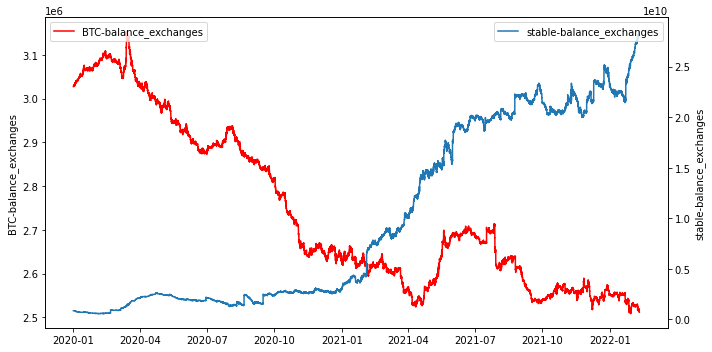

In [13]:
df1.plot2('BTC-balance_exchanges','stable-balance_exchanges')

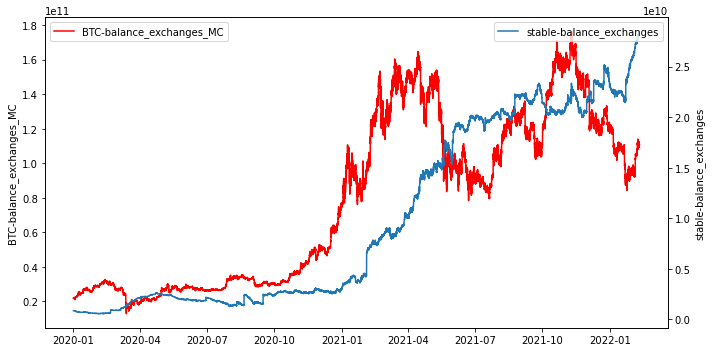

In [14]:
df1.plot2('BTC-balance_exchanges_MC','stable-balance_exchanges')

In [144]:
df1['BTCSSR'] = df1['BTC-balance_exchanges_MC']/df2['stable-balance_exchanges']
df2 = df1.drop('BTC-balance_exchanges_MC', axis=1).dropna()

<AxesSubplot:>

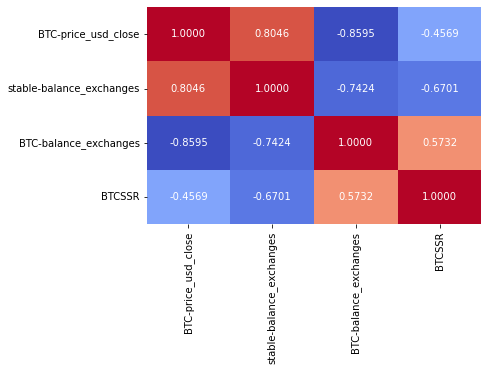

In [146]:
fig, ax = plt.subplots()
sns.heatmap(df2.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

In [186]:
df3 = df2.copy()
df3['ret'] = df3['BTC-price_usd_close'].pct_change()
df3['stable_bal_chg'] = df3['stable-balance_exchanges'].diff()
df3['stable_bal_chg_lag1'] = df3['stable_bal_chg'].shift(1)
df3['BTCSSR_lag1'] = df3['BTCSSR'].shift(1)
df3['BTCSSR_chg'] = df3['BTCSSR'].diff()
df3['BTCSSR_chg_lag1'] = df3['BTCSSR_chg'].shift(1)
df3['r+5'] = df3['ret'].pct_change(periods=5).shift(-5)
df3['r+10'] = df3['ret'].pct_change(periods=10).shift(10)
df3['r+100'] = df3['ret'].pct_change(periods=100).shift(100)

In [187]:
df3.dropna().count()

BTC-price_usd_close         109538
stable-balance_exchanges    109538
BTC-balance_exchanges       109538
BTCSSR                      109538
ret                         109538
stable_bal_chg              109538
stable_bal_chg_lag1         109538
BTCSSR_lag1                 109538
BTCSSR_chg                  109538
BTCSSR_chg_lag1             109538
r+5                         109538
r+10                        109538
r+100                       109538
dtype: int64

In [189]:
df4 = df3.dropna()[['stable_bal_chg','stable_bal_chg_lag1','BTCSSR','BTCSSR_chg','BTCSSR_chg_lag1','ret','r+5','r+10','r+100']]

In [190]:
df4.count()

stable_bal_chg         109538
stable_bal_chg_lag1    109538
BTCSSR                 109538
BTCSSR_chg             109538
BTCSSR_chg_lag1        109538
ret                    109538
r+5                    109538
r+10                   109538
r+100                  109538
dtype: int64

In [191]:
df4a = df4.where(~np.isinf(df4), 0)
df4a

,stable_bal_chg,stable_bal_chg_lag1,BTCSSR,BTCSSR_chg,BTCSSR_chg_lag1,ret,r+5,r+10,r+100
t,,,,,,,,,
2020-01-02 09:30:00,-1.676253e+05,5.898457e+04,25.639222,-0.005934,0.007058,-0.000430,-3.132431,-1.016726,-1.112241
2020-01-02 09:40:00,1.613140e+06,-1.676253e+05,25.590701,-0.048521,-0.005934,0.000012,63.203929,-0.993660,-6.304511
2020-01-02 09:50:00,-1.403237e+06,1.613140e+06,25.649847,0.059146,-0.048521,0.000650,-1.573624,53.166452,-12.920023
2020-01-02 10:00:00,1.252565e+06,-1.403237e+06,25.621692,-0.028155,0.059146,0.000462,-3.763404,0.792022,18.530413
2020-01-02 10:10:00,7.286306e+05,1.252565e+06,25.625387,0.003695,-0.028155,0.001005,-0.295189,-1.223528,4.622350
...,...,...,...,...,...,...,...,...,...
2022-02-03 02:20:00,6.856949e+06,8.045708e+05,3.515005,-0.000252,-0.007038,0.000126,-7.528049,-0.886784,-0.920690
2022-02-03 02:30:00,5.184905e+06,6.856949e+06,3.520960,0.005955,-0.000252,0.001826,-0.982847,-0.553795,-1.177071
2022-02-03 02:40:00,-8.146855e+06,5.184905e+06,3.524014,0.003054,0.005955,0.000559,-4.193313,-0.652487,-0.885825


<AxesSubplot:>

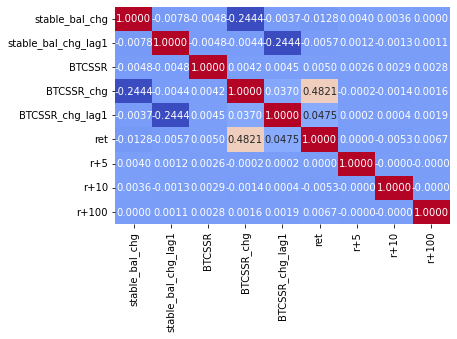

In [192]:
fig, ax = plt.subplots()
sns.heatmap(df4a.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

In [ ]:
calculate_corr_pvalues(df4a)

### backtes